In [1]:
import os, glob,inspect
import copy
import numpy as np
import pandas as pd
# pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', 200)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import rankdata
from scipy import stats
from datetime import datetime, timedelta

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, _tree
from sklearn import metrics
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import mixture
from math import pi
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from kneed import DataGenerator, KneeLocator
from sklearn import tree
import string
from sklearn.tree import export_text
from sklearn.preprocessing import LabelEncoder
from pprint import pprint
import sympy as sym
from sympy import solve


cwd = os.getcwd()
today = datetime.today().strftime('%Y-%m-%d')
min_cluster = 3
price_step = 0.01

print(cwd)
print(today)

/home/cst/SmartTradzt/PriceOptimisation
2021-07-26


In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def export_py_code(tree, feature_names, max_depth=100, spacing=4):
    if spacing < 2:
        raise ValueError('spacing must be > 1')

    # Clean up feature names (for correctness)
    nums = string.digits
    alnums = string.ascii_letters + nums
    clean = lambda s: ''.join(c if c in alnums else '_' for c in s)
    features = [clean(x) for x in feature_names]
    features = ['_'+x if x[0] in nums else x for x in features if x]
    if len(set(features)) != len(feature_names):
        raise ValueError('invalid feature names')

    # First: export tree to text
    res = export_text(tree, feature_names=features, 
                        max_depth=max_depth,
                        decimals=6,
                        spacing=spacing-1)

    # Second: generate Python code from the text
    skip, dash = ' '*spacing, '-'*(spacing-1)
    code = 'def decision_tree({}):\n'.format(', '.join(features))
    for line in repr(tree).split('\n'):
        code += skip + "# " + line + '\n'
    for line in res.split('\n'):
        line = line.rstrip().replace('|',' ')
        if '<' in line or '>' in line:
            line, val = line.rsplit(maxsplit=1)
            line = line.replace(' ' + dash, 'if')
            line = '{} {:g}:'.format(line, float(val))
        else:
            line = line.replace(' {} class:'.format(dash), 'return')
        code += skip + line + '\n'

    return code.replace('- value:','return').replace('-','')

def get_func_args(f):
    if hasattr(f, 'args'):
        return f.args
    else:
        return list(inspect.signature(f).parameters)

def tree_to_df(reg_tree, feature_names):
    tree_ = reg_tree.tree_
    feature_name = [
        feature_names[i] if i != sklearn.tree._tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    
    def recurse(node, row, ret):
        if tree_.feature[node] != sklearn.tree._tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            # Add rule to row and search left branch
            row[-1].append(name + " <= " +  str(threshold))
            recurse(tree_.children_left[node], row, ret)
            # Add rule to row and search right branch
            row[-1].append(name + " > " +  str(threshold))
            recurse(tree_.children_right[node], row, ret)
        else:
            # Add output rules and start a new row
            label = tree_.value[node]
            ret.append("return " + str(label[0][0]))
            row.append([])
    
    # Initialize
    rules = [[]]
    vals = []
    
    # Call recursive function with initial values
    recurse(0, rules, vals)
    
    # Convert to table and output
    df = pd.DataFrame(rules).dropna(how='all')
    df['Return'] = pd.Series(vals)
    return df


In [3]:
filename = 'Price_Opti_Input.csv'
filepath = os.path.join(cwd,filename)
print(filepath)

/home/cst/SmartTradzt/PriceOptimisation/Price_Opti_Input.csv


In [4]:
df = pd.read_csv(filepath)
df.head()

,Customer,Product_Group,Recency,Avg_Price_L3Y,Revenue_L12,Customer_Size,l3y_volume,standard_cost,l12_sales_vol,Current_Price
0,10018,Product_A,9,29.3,243,38827.46,34.89,10,11.6,32.23
1,10024,Product_A,5,53.6,627,4051.66,42.84,10,14.3,58.96
2,10031,Product_A,2,60.6,2362,12182.45,116.86,10,39.0,66.66
3,10064,Product_A,5,39.8,336,31729.38,26.61,10,8.9,43.78
4,10117,Product_A,12,37.5,135,135.11,3.60,10,1.2,41.25


In [5]:
df.shape

(2147, 10)

In [6]:
df = pd.read_csv(filepath)
df.head()

,Customer,Product_Group,Recency,Avg_Price_L3Y,Revenue_L12,Customer_Size,l3y_volume,standard_cost,l12_sales_vol,Current_Price
0,10018,Product_A,9,29.3,243,38827.46,34.89,10,11.6,32.23
1,10024,Product_A,5,53.6,627,4051.66,42.84,10,14.3,58.96
2,10031,Product_A,2,60.6,2362,12182.45,116.86,10,39.0,66.66
3,10064,Product_A,5,39.8,336,31729.38,26.61,10,8.9,43.78
4,10117,Product_A,12,37.5,135,135.11,3.60,10,1.2,41.25


In [7]:
df.dtypes

Customer           int64
Product_Group     object
Recency            int64
Avg_Price_L3Y    float64
Revenue_L12        int64
Customer_Size    float64
l3y_volume       float64
standard_cost      int64
l12_sales_vol    float64
Current_Price    float64
dtype: object

# Segmentation

In [8]:
features = ['Revenue_L12', 'Recency', 'Customer_Size']

clf = DecisionTreeRegressor(max_depth=3, min_samples_split=100, random_state=42, ccp_alpha=0.001)
clf.fit(df[['Revenue_L12', 'Recency', 'Customer_Size']],df['Avg_Price_L3Y'])

DecisionTreeRegressor(ccp_alpha=0.001, max_depth=3, min_samples_split=100,
                      random_state=42)

In [9]:
text_representation = tree.export_text(clf, feature_names=features)
print(text_representation)

|--- Revenue_L12 <= 174.50
|   |--- Revenue_L12 <= 145.50
|   |   |--- Customer_Size <= 128.53
|   |   |   |--- value: [57.17]
|   |   |--- Customer_Size >  128.53
|   |   |   |--- value: [35.72]
|   |--- Revenue_L12 >  145.50
|   |   |--- Recency <= 2.50
|   |   |   |--- value: [49.05]
|   |   |--- Recency >  2.50
|   |   |   |--- value: [41.50]
|--- Revenue_L12 >  174.50
|   |--- Customer_Size <= 7481.66
|   |   |--- Revenue_L12 <= 202.50
|   |   |   |--- value: [46.55]
|   |   |--- Revenue_L12 >  202.50
|   |   |   |--- value: [51.16]
|   |--- Customer_Size >  7481.66
|   |   |--- Customer_Size <= 37720.68
|   |   |   |--- value: [42.45]
|   |   |--- Customer_Size >  37720.68
|   |   |   |--- value: [31.60]



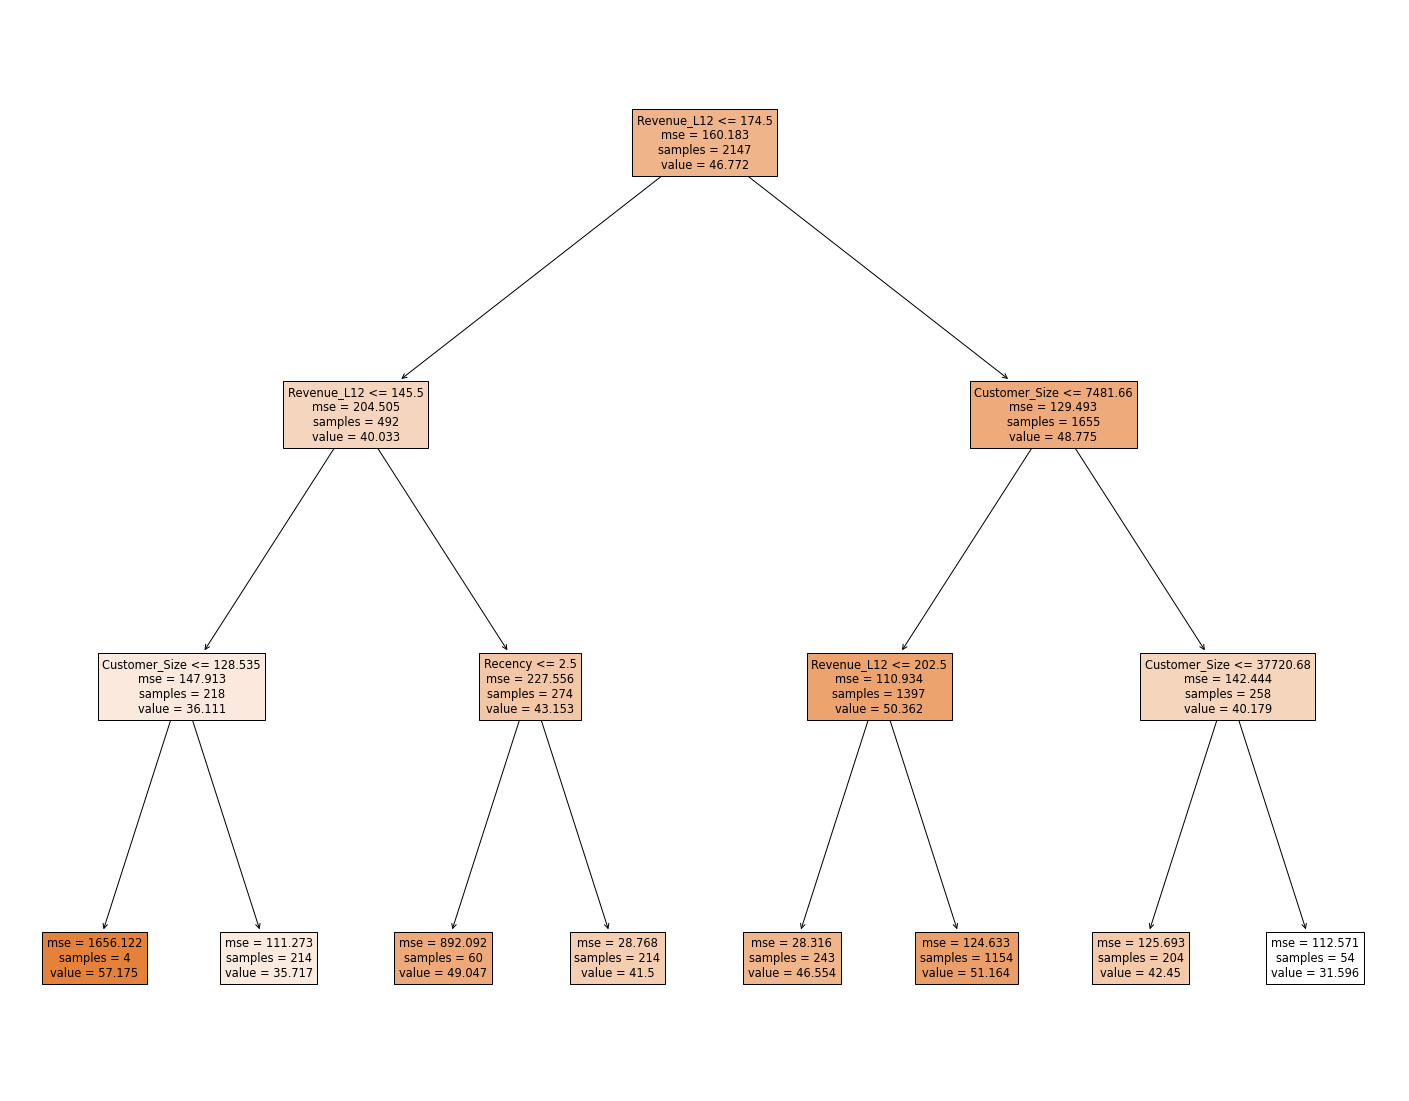

In [10]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=features,
                   filled=True)

In [11]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules


In [12]:
rules = get_rules(clf, features, None)
rules_dict = {}
for i,r in enumerate(rules):    
    rules_dict[i] = r
    

In [13]:
rules_dict

{0: 'if (Revenue_L12 > 174.5) and (Customer_Size <= 7481.66) and (Revenue_L12 > 202.5) then response: 51.164 | based on 1,154 samples',
 1: 'if (Revenue_L12 > 174.5) and (Customer_Size <= 7481.66) and (Revenue_L12 <= 202.5) then response: 46.554 | based on 243 samples',
 2: 'if (Revenue_L12 <= 174.5) and (Revenue_L12 > 145.5) and (Recency > 2.5) then response: 41.5 | based on 214 samples',
 3: 'if (Revenue_L12 <= 174.5) and (Revenue_L12 <= 145.5) and (Customer_Size > 128.535) then response: 35.717 | based on 214 samples',
 4: 'if (Revenue_L12 > 174.5) and (Customer_Size > 7481.66) and (Customer_Size <= 37720.68) then response: 42.45 | based on 204 samples',
 5: 'if (Revenue_L12 <= 174.5) and (Revenue_L12 > 145.5) and (Recency <= 2.5) then response: 49.047 | based on 60 samples',
 6: 'if (Revenue_L12 > 174.5) and (Customer_Size > 7481.66) and (Customer_Size > 37720.68) then response: 31.596 | based on 54 samples',
 7: 'if (Revenue_L12 <= 174.5) and (Revenue_L12 <= 145.5) and (Customer_S

In [14]:
rules_df = tree_to_df(clf, features)

In [15]:
rules_df['rule_no'] = rules_df.index+1

In [16]:
rules_df

,0,1,2,Return,rule_no
0,Revenue_L12 <= 174.5,Revenue_L12 <= 145.5,Customer_Size <= 128.5349998474121,return 57.175,1
1,Customer_Size > 128.5349998474121,None,None,return 35.71682242990654,2
2,Revenue_L12 > 145.5,Recency <= 2.5,None,return 49.04666666666665,3
3,Recency > 2.5,None,None,return 41.50046728971964,4
4,Revenue_L12 > 174.5,Customer_Size <= 7481.659912109375,Revenue_L12 <= 202.5,return 46.55390946502058,5
5,Revenue_L12 > 202.5,None,None,return 51.16447140381288,6
6,Customer_Size > 7481.659912109375,Customer_Size <= 37720.6796875,None,return 42.45049019607843,7
7,Customer_Size > 37720.6796875,None,None,return 31.596296296296302,8


In [17]:
df

,Customer,Product_Group,Recency,Avg_Price_L3Y,Revenue_L12,Customer_Size,l3y_volume,standard_cost,l12_sales_vol,Current_Price
0,10018,Product_A,9,29.3,243,38827.46,34.89,10,11.6,32.23
1,10024,Product_A,5,53.6,627,4051.66,42.84,10,14.3,58.96
2,10031,Product_A,2,60.6,2362,12182.45,116.86,10,39.0,66.66
3,10064,Product_A,5,39.8,336,31729.38,26.61,10,8.9,43.78
4,10117,Product_A,12,37.5,135,135.11,3.60,10,1.2,41.25
...,...,...,...,...,...,...,...,...,...,...
2142,8995442,Product_A,11,18.8,291,7520.45,28.74,10,9.6,20.68
2143,8996178,Product_A,8,28.7,119,1365.62,7.90,10,2.6,31.57
2144,8996426,Product_A,6,38.9,162,1165.76,19.11,10,6.4,42.79
2145,8996563,Product_A,2,43.8,164,456.95,3.74,10,1.2,48.18


In [18]:
res = export_py_code(clf, feature_names=features, spacing=4)
print(res)

def decision_tree(Revenue_L12, Recency, Customer_Size):
    # DecisionTreeRegressor(ccp_alpha=0.001, max_depth=3, min_samples_split=100,
    #                       random_state=42)
    if Revenue_L12 <= 174.5:
        if Revenue_L12 <= 145.5:
            if Customer_Size <= 128.535:
                 return [57.175000]
            if Customer_Size > 128.535:
                 return [35.716822]
        if Revenue_L12 > 145.5:
            if Recency <= 2.5:
                 return [49.046667]
            if Recency > 2.5:
                 return [41.500467]
    if Revenue_L12 > 174.5:
        if Customer_Size <= 7481.66:
            if Revenue_L12 <= 202.5:
                 return [46.553909]
            if Revenue_L12 > 202.5:
                 return [51.164471]
        if Customer_Size > 7481.66:
            if Customer_Size <= 37720.7:
                 return [42.450490]
            if Customer_Size > 37720.7:
                 return [31.596296]
    



In [19]:
with open('DecisionTreeRegressorRML.py', 'w') as f:
    f.write(res)    

In [20]:
from DecisionTreeRegressorRML import decision_tree

In [21]:
text_function = str(decision_tree.__name__)+'('+','.join([item+"=x['"+item+"']" for item in get_func_args(decision_tree)])+')'
text_function

"decision_tree(Revenue_L12=x['Revenue_L12'],Recency=x['Recency'],Customer_Size=x['Customer_Size'])"

In [22]:
df['node'] = df.apply(lambda x: eval(text_function), axis=1) 
df['node'] = df['node'].apply(lambda x:str(x).replace('[','').replace(']',''))

In [23]:
le = LabelEncoder()
df['segment'] = le.fit_transform(df['node'])

In [24]:
df

,Customer,Product_Group,Recency,Avg_Price_L3Y,Revenue_L12,Customer_Size,l3y_volume,standard_cost,l12_sales_vol,Current_Price,node,segment
0,10018,Product_A,9,29.3,243,38827.46,34.89,10,11.6,32.23,31.596296,0
1,10024,Product_A,5,53.6,627,4051.66,42.84,10,14.3,58.96,51.164471,6
2,10031,Product_A,2,60.6,2362,12182.45,116.86,10,39.0,66.66,42.45049,3
3,10064,Product_A,5,39.8,336,31729.38,26.61,10,8.9,43.78,42.45049,3
4,10117,Product_A,12,37.5,135,135.11,3.60,10,1.2,41.25,35.716822,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2142,8995442,Product_A,11,18.8,291,7520.45,28.74,10,9.6,20.68,42.45049,3
2143,8996178,Product_A,8,28.7,119,1365.62,7.90,10,2.6,31.57,35.716822,1
2144,8996426,Product_A,6,38.9,162,1165.76,19.11,10,6.4,42.79,41.500467,2
2145,8996563,Product_A,2,43.8,164,456.95,3.74,10,1.2,48.18,49.046667,5


# Elastisicity Function per Segment

In [25]:
df = df.loc[df['l3y_volume']>0]
df = df.loc[df['Avg_Price_L3Y']>0]

In [26]:
df.shape

(2147, 12)

In [27]:
df.loc[:,'lnvolume'] = np.log(df.loc[:,'l3y_volume'])
df.loc[:,'lnAvg_Price_L3Y'] = np.log(df.loc[:,'Avg_Price_L3Y'])

In [28]:
df

,Customer,Product_Group,Recency,Avg_Price_L3Y,Revenue_L12,Customer_Size,l3y_volume,standard_cost,l12_sales_vol,Current_Price,node,segment,lnvolume,lnAvg_Price_L3Y
0,10018,Product_A,9,29.3,243,38827.46,34.89,10,11.6,32.23,31.596296,0,3.552200,3.377588
1,10024,Product_A,5,53.6,627,4051.66,42.84,10,14.3,58.96,51.164471,6,3.757472,3.981549
2,10031,Product_A,2,60.6,2362,12182.45,116.86,10,39.0,66.66,42.45049,3,4.760977,4.104295
3,10064,Product_A,5,39.8,336,31729.38,26.61,10,8.9,43.78,42.45049,3,3.281287,3.683867
4,10117,Product_A,12,37.5,135,135.11,3.60,10,1.2,41.25,35.716822,1,1.280934,3.624341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2142,8995442,Product_A,11,18.8,291,7520.45,28.74,10,9.6,20.68,42.45049,3,3.358290,2.933857
2143,8996178,Product_A,8,28.7,119,1365.62,7.90,10,2.6,31.57,35.716822,1,2.066863,3.356897
2144,8996426,Product_A,6,38.9,162,1165.76,19.11,10,6.4,42.79,41.500467,2,2.950212,3.660994
2145,8996563,Product_A,2,43.8,164,456.95,3.74,10,1.2,48.18,49.046667,5,1.319086,3.779634


In [29]:
lin_regs = {}

features = ['lnAvg_Price_L3Y']
target = ['lnvolume']

for segment in df['segment'].unique():
    
    print('segment:',segment)
    sub = df[df['segment']==segment]
    
    lin_reg = LinearRegression()
    lin_reg.fit(sub[features].values,sub[target].values.reshape(-1, 1))
    print(lin_reg.intercept_,lin_reg.coef_)
    
    lin_regs[segment] = {}
    lin_regs[segment]['intercept_'] = lin_reg.intercept_[0]
    lin_regs[segment]['coef_'] = lin_reg.coef_[0]    

segment: 0
[9.27666951] [[-1.45293861]]
segment: 6
[7.35232117] [[-1.14285895]]
segment: 3
[5.24290042] [[-0.2691711]]
segment: 1
[3.96884438] [[-0.55282215]]
segment: 2
[7.79123089] [[-1.52279876]]
segment: 4
[6.76830656] [[-1.19685004]]
segment: 5
[3.12018604] [[-0.28304676]]
segment: 7
[1.18332258] [[0.02654909]]


In [30]:
lin_regs

{0: {'intercept_': 9.27666951451969, 'coef_': array([-1.45293861])},
 6: {'intercept_': 7.352321168603478, 'coef_': array([-1.14285895])},
 3: {'intercept_': 5.242900417117241, 'coef_': array([-0.2691711])},
 1: {'intercept_': 3.968844375944699, 'coef_': array([-0.55282215])},
 2: {'intercept_': 7.791230885275283, 'coef_': array([-1.52279876])},
 4: {'intercept_': 6.768306562405984, 'coef_': array([-1.19685004])},
 5: {'intercept_': 3.1201860417757703, 'coef_': array([-0.28304676])},
 7: {'intercept_': 1.183322580471354, 'coef_': array([0.02654909])}}

In [31]:
df['lin_reg'] = df['segment'].map(lin_regs)

In [32]:
df['elasticity'] = df['lin_reg'].apply(lambda x:dict(x)['intercept_'])

In [35]:
df['AVG_PE'] = df['elasticity'].mean()

In [37]:
df['elasticity'] = np.where(df['elasticity']>=-0.3,df['AVG_PE'],df['elasticity'])

<AxesSubplot:>

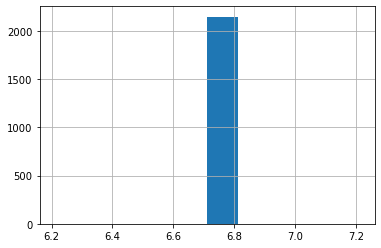

In [39]:
df['elasticity'].hist()

<b>Is it right to use population threshold to limit PE? This exercise will ignore this part.</b>

In [50]:
df['elasticity'] = df['lin_reg'].apply(lambda x:dict(x)['intercept_'])

In [51]:
# df['AVG_PE_per_segment'] =  df.groupby('segment')['elasticity'].transform(mean)
# df.groupby(['segment']).aggregate({'elasticity':np.mean}).reset_index()

<AxesSubplot:>

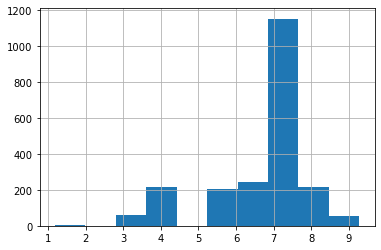

In [53]:
df['elasticity'].hist()

In [52]:
df

,Customer,Product_Group,Recency,Avg_Price_L3Y,Revenue_L12,Customer_Size,l3y_volume,standard_cost,l12_sales_vol,Current_Price,node,segment,lnvolume,lnAvg_Price_L3Y,lin_reg,elasticity,AVG_PE
0,10018,Product_A,9,29.3,243,38827.46,34.89,10,11.6,32.23,31.596296,0,3.552200,3.377588,"{'intercept_': 9.27666951451969, 'coef_': [-1....",9.276670,6.710931
1,10024,Product_A,5,53.6,627,4051.66,42.84,10,14.3,58.96,51.164471,6,3.757472,3.981549,"{'intercept_': 7.352321168603478, 'coef_': [-1...",7.352321,6.710931
2,10031,Product_A,2,60.6,2362,12182.45,116.86,10,39.0,66.66,42.45049,3,4.760977,4.104295,"{'intercept_': 5.242900417117241, 'coef_': [-0...",5.242900,6.710931
3,10064,Product_A,5,39.8,336,31729.38,26.61,10,8.9,43.78,42.45049,3,3.281287,3.683867,"{'intercept_': 5.242900417117241, 'coef_': [-0...",5.242900,6.710931
4,10117,Product_A,12,37.5,135,135.11,3.60,10,1.2,41.25,35.716822,1,1.280934,3.624341,"{'intercept_': 3.968844375944699, 'coef_': [-0...",3.968844,6.710931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2142,8995442,Product_A,11,18.8,291,7520.45,28.74,10,9.6,20.68,42.45049,3,3.358290,2.933857,"{'intercept_': 5.242900417117241, 'coef_': [-0...",5.242900,6.710931
2143,8996178,Product_A,8,28.7,119,1365.62,7.90,10,2.6,31.57,35.716822,1,2.066863,3.356897,"{'intercept_': 3.968844375944699, 'coef_': [-0...",3.968844,6.710931
2144,8996426,Product_A,6,38.9,162,1165.76,19.11,10,6.4,42.79,41.500467,2,2.950212,3.660994,"{'intercept_': 7.791230885275283, 'coef_': [-1...",7.791231,6.710931
2145,8996563,Product_A,2,43.8,164,456.95,3.74,10,1.2,48.18,49.046667,5,1.319086,3.779634,"{'intercept_': 3.1201860417757703, 'coef_': [-...",3.120186,6.710931


In [54]:
# write.csv2(df1,'df1.csv')
df.to_csv('df1.csv',index=False)

# Optimisation per Segment

In [ ]:
revenue_df= pd.DataFrame()

for k,v, in lin_regs.items():
    
#     print(k,v)
    
    segment = k
    
    sub_df = df[df['segment']==segment]
    
    min_price = sub_df['Price'].min()
    max_price = sub_df['Price'].max()
    
    Price = [i for i in np.arange(sub_df['Price'].min(), sub_df['Price'].max(), step)]
#     print(segment,Price)

    Revenue = []
    
    for i in Price:
    
        quantity_demanded = eval(quantity_function_text.replace('Price',str(i)))       
        Revenue.append((i-standard_cost) * quantity_demanded)
        
    profit = pd.DataFrame({"Price": Price, "Revenue": Revenue})
    profit['Segment'] = segment 
    
    revenue_df = pd.concat([revenue_df,profit])
    

In [ ]:
revenue_df

In [ ]:
revenue_df.groupby(['Segment']).aggregate({'Price':[np.min,np.max]})

In [ ]:
for segment in revenue_df['Segment'].unique():
    
    sub = revenue_df[revenue_df['Segment']==segment]
    
    #plot revenue against price
    plt.plot(sub["Price"], sub["Revenue"])    
    plt.axvline(x=np.array(sub[sub['Revenue'] == sub['Revenue'].max()]['Price'])[0], c='red')
    plt.title('Segment {}, Max Revenue at {}'.format(segment,np.array(sub[sub['Revenue'] == sub['Revenue'].max()]['Price'])[0]))
    plt.show()

# End Here